In [1]:
import torch, shap, glob, os
import numpy as np, pandas as pd, torchvision.transforms as transforms
import random

from tqdm.notebook import tqdm
from torch.nn import Module
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [2]:
npy_path = './np_image_totalunit/tsne-binary-perplexity=5-pixel=400[onehot]/'
# npy_path = './np_image_totalunit/multiclass_totalunit/'

save_weight_path ='./models/weights_res18_tsne-binary-perplexity=5-pixel=400[onehot]/'
if not os.path.exists(save_weight_path):
    os.mkdir(save_weight_path)

# save_weight_path = './models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/'

weights_name = "weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.05.09-onehot.pt"
# weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt"

path2weights = os.path.join(save_weight_path,weights_name)

In [3]:
npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
label_ = np.load(os.path.join(npy_path,'label.npy'))

In [4]:
label_[0:30]

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1])

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)

print(len(X_train), len(y_train)) 

print(len(X_test), len(y_test))

851 851
284 284


In [6]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels, transform):
        self.transform = transform
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = np.load(self.s_path[idx]).astype(np.float32)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = self.transform(singel_image_)
        label = float(self.labels[idx])
        # print(label)

        return singel_image_, label

In [7]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean, std),
            ])     

train_ds = TransferDataset(s_path= X_train, labels= y_train, transform= transformer)
test_ds = TransferDataset(s_path= X_test, labels= y_test, transform= transformer)
print(len(train_ds), len(test_ds))

851 284


In [8]:
from torchvision.models import alexnet, resnet18
from torch.nn import Module
from torch import nn
# model = resnet18(pretrained=False, num_classes=max(label_)+1)
model = resnet18(pretrained=False, num_classes=1)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# model

In [9]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# loss_func = nn.CrossEntropyLoss(reduction="sum", weight=class_weights)
# loss_func = nn.CrossEntropyLoss(reduction="sum")
loss_func = nn.BCELoss(reduction='mean')
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)
# path2weights = "./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.22.pt"
# torch.save(model.state_dict(), path2weights)
params_train={
    "num_epochs": 150,
    "optimizer": opt,
    "loss_func": loss_func,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2weights,
    }

In [10]:
import copy
import datetime
from tqdm import tqdm_notebook
from sklearn import metrics
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

class logs_realtime_reply:
    def __init__(self):
        self.avg_loss=np.inf
        self.running_metic = {"Loss":0, "Accuracy":0, "AUC":0}
        self.end_epoch_metric = None
    def metric_stack(self, inputs, targets, loss):
        self.running_metic['Loss'] +=loss
        acc = metrics.accuracy_score(targets.cpu().detach().numpy(), inputs.cpu().detach().numpy()>0.5)
        fpr, tpr, _ = metrics.roc_curve(targets.cpu().detach().numpy(), inputs.cpu().detach().numpy(), pos_label=1)
        self.running_metic['Accuracy'] += np.round(acc, 5)*100
        self.running_metic['AUC'] += np.round(metrics.auc(fpr, tpr), 5)*100
    def mini_batch_reply(self, current_step, epoch, iter_len):
        # avg_reply_metric = {"Loss":None, "TP":None, "FP":None, "FN": None, "Spec": None, "Sens": None}
        avg_reply_metric = {"Loss":None, "Accuracy": None, "AUC": None}
        for j in avg_reply_metric:
            avg_reply_metric[j] = round(self.running_metic[j]/int(current_step),5)
        
        if current_step ==iter_len:
            self.end_epoch_metric = avg_reply_metric
        return avg_reply_metric
    def epoch_reply(self):
        return self.end_epoch_metric
        
def train(train_loader, model, criterion, optimizer, epoch):
    get_logs_reply = logs_realtime_reply()
    model.train()
    stream = tqdm(train_loader)
   
    for i, (image, label) in enumerate(stream, start=1):
        
        image=image.to(device)
        label=label.to(device).float()
        output=torch.squeeze(torch.sigmoid(model(image)))
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(optimizer, 0.5)
        optimizer.step()
        
        get_logs_reply.metric_stack(output, label, loss = round(loss.item(), 5))
        avg_reply_metric = get_logs_reply.mini_batch_reply(i, epoch, len(stream))
        avg_reply_metric['lr'] = optimizer.param_groups[0]['lr']
        stream.set_description(f"Epoch: {epoch}. Train. {str(avg_reply_metric)}")
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy'], avg_reply_metric['AUC']
# model validate
def validate(valid_loader, model, criterion, epoch):
    global best_vloss, best_vacc
    get_logs_reply2 = logs_realtime_reply()
    model.eval()
    stream_v = tqdm(valid_loader)
    with torch.no_grad():
        for i, (image, label) in enumerate(stream_v, start=1):
            image=image.to(device)
            label=label.to(device).float()
            output=torch.squeeze(torch.sigmoid(model(image)))
            loss = criterion(output, label)
            get_logs_reply2.metric_stack(output, label, loss = round(loss.item(), 5))
            avg_reply_metric = get_logs_reply2.mini_batch_reply(i, epoch, len(stream_v))
            stream_v.set_description(f"Epoch: {epoch}. Valid. {str(avg_reply_metric)}")
        avg_reply_metric = get_logs_reply2.epoch_reply()

    for x in avg_reply_metric:
        if x=='Loss' and avg_reply_metric[x]<best_vloss:
            best_vloss = avg_reply_metric[x]
            current_loss = avg_reply_metric['Loss']
            best_ck_name = path2weights
            torch.save({
                    'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(), 
                    'loss':  current_loss,}, best_ck_name)
            print('save...', best_ck_name)
    return avg_reply_metric['Loss'], avg_reply_metric['Accuracy'], avg_reply_metric['AUC']

def  train_valid_process_main(model):
    global best_vloss, best_vacc
    best_vloss = np.inf
    best_vacc = 0.00
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }

    auc_history={
        "train": [],
        "val": [],
    }
    # Subject Dataloader Building
    batch_size = 32
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                            shuffle=True)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                            shuffle=False)  

    for epoch in range(1, params_train["num_epochs"] + 1):
        train_loss, train_metric, train_auc = train(train_dl, model, loss_func, opt, epoch)
        val_loss, val_metric, val_auc = validate(test_dl, model, loss_func, epoch)
        print("Epoch: ",epoch, f" Train/Valid Loss: {train_loss}|{val_loss}  ", f" Train/Valid Accuracy: {train_metric}|{val_metric}")
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        auc_history["train"].append(train_auc)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        auc_history["val"].append(val_auc)
        lr_scheduler.step(val_loss)
    return loss_history, metric_history, auc_history

In [11]:
loss_history, metric_history,auc_history  = train_valid_process_main(model)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

save... ./models/weights_res18_tsne-binary-perplexity=5-pixel=400[onehot]/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.05.09-onehot.pt
Epoch:  1  Train/Valid Loss: 0.69984|0.68042    Train/Valid Accuracy: 55.19615|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  2  Train/Valid Loss: 0.61317|1.38881    Train/Valid Accuracy: 66.65448|58.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

save... ./models/weights_res18_tsne-binary-perplexity=5-pixel=400[onehot]/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.05.09-onehot.pt
Epoch:  3  Train/Valid Loss: 0.46841|0.54852    Train/Valid Accuracy: 77.7717|73.5714


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  4  Train/Valid Loss: 0.37888|1.77868    Train/Valid Accuracy: 84.0217|41.1162


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

save... ./models/weights_res18_tsne-binary-perplexity=5-pixel=400[onehot]/weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.05.09-onehot.pt
Epoch:  5  Train/Valid Loss: 0.34106|0.49957    Train/Valid Accuracy: 85.09989|80.4018


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  6  Train/Valid Loss: 0.26319|2.58525    Train/Valid Accuracy: 91.12452|59.2858


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  7  Train/Valid Loss: 0.30211|3.62144    Train/Valid Accuracy: 86.95785|59.2858


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  8  Train/Valid Loss: 0.21889|0.64942    Train/Valid Accuracy: 91.16107|75.5358


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  9  Train/Valid Loss: 0.22099|0.75974    Train/Valid Accuracy: 91.08189|72.7232


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  10  Train/Valid Loss: 0.15852|0.54932    Train/Valid Accuracy: 94.6333|84.3302


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  11  Train/Valid Loss: 0.16121|0.97175    Train/Valid Accuracy: 93.78656|69.509
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  12  Train/Valid Loss: 0.10963|1.14618    Train/Valid Accuracy: 96.17448|60.8482


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  13  Train/Valid Loss: 0.0813|0.7211    Train/Valid Accuracy: 97.4537|77.4998


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  14  Train/Valid Loss: 0.04973|0.60943    Train/Valid Accuracy: 98.30044|80.089


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  15  Train/Valid Loss: 0.05008|0.64274    Train/Valid Accuracy: 98.49537|81.2052


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  16  Train/Valid Loss: 0.04738|0.51685    Train/Valid Accuracy: 98.49537|81.7414


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  17  Train/Valid Loss: 0.01909|0.66519    Train/Valid Accuracy: 99.53704|83.7052
Epoch 00017: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  18  Train/Valid Loss: 0.01479|0.62872    Train/Valid Accuracy: 99.53704|81.4286


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  19  Train/Valid Loss: 0.01683|0.81126    Train/Valid Accuracy: 99.53704|83.393


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  20  Train/Valid Loss: 0.01447|0.68252    Train/Valid Accuracy: 99.65278|83.0802


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  21  Train/Valid Loss: 0.0109|0.74759    Train/Valid Accuracy: 99.76852|84.018


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  22  Train/Valid Loss: 0.00984|1.09043    Train/Valid Accuracy: 99.88426|81.0266


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  23  Train/Valid Loss: 0.00682|0.66206    Train/Valid Accuracy: 99.88426|83.0804
Epoch 00023: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  24  Train/Valid Loss: 0.00299|0.7085    Train/Valid Accuracy: 100.0|83.0802


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  25  Train/Valid Loss: 0.0052|0.7272    Train/Valid Accuracy: 99.88426|84.3306


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  26  Train/Valid Loss: 0.0034|0.67234    Train/Valid Accuracy: 100.0|83.393


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  27  Train/Valid Loss: 0.00236|0.68569    Train/Valid Accuracy: 100.0|83.0806


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  28  Train/Valid Loss: 0.0022|0.72255    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  29  Train/Valid Loss: 0.00328|0.72991    Train/Valid Accuracy: 100.0|83.7054
Epoch 00029: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  30  Train/Valid Loss: 0.0015|0.70678    Train/Valid Accuracy: 100.0|83.7054


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  31  Train/Valid Loss: 0.00141|0.71996    Train/Valid Accuracy: 100.0|83.393


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  32  Train/Valid Loss: 0.0027|0.73466    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  33  Train/Valid Loss: 0.00202|0.71306    Train/Valid Accuracy: 100.0|83.7054


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  34  Train/Valid Loss: 0.00156|0.72989    Train/Valid Accuracy: 100.0|83.7054


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  35  Train/Valid Loss: 0.00137|0.73701    Train/Valid Accuracy: 100.0|83.7052
Epoch 00035: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  36  Train/Valid Loss: 0.00192|0.73475    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  37  Train/Valid Loss: 0.002|0.73954    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  38  Train/Valid Loss: 0.00146|0.73739    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  39  Train/Valid Loss: 0.00183|0.74316    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  40  Train/Valid Loss: 0.00124|0.7473    Train/Valid Accuracy: 100.0|83.0802


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  41  Train/Valid Loss: 0.00105|0.73672    Train/Valid Accuracy: 100.0|83.3928
Epoch 00041: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  42  Train/Valid Loss: 0.00298|0.74857    Train/Valid Accuracy: 100.0|83.393


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  43  Train/Valid Loss: 0.00141|0.76019    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  44  Train/Valid Loss: 0.00139|0.76541    Train/Valid Accuracy: 100.0|82.768


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  45  Train/Valid Loss: 0.00139|0.7622    Train/Valid Accuracy: 100.0|82.7678


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  46  Train/Valid Loss: 0.00137|0.75683    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  47  Train/Valid Loss: 0.00119|0.74853    Train/Valid Accuracy: 100.0|83.0804
Epoch 00047: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  48  Train/Valid Loss: 0.00134|0.75268    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  49  Train/Valid Loss: 0.00103|0.74967    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  50  Train/Valid Loss: 0.00181|0.75723    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  51  Train/Valid Loss: 0.00141|0.74954    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  52  Train/Valid Loss: 0.00117|0.75825    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  53  Train/Valid Loss: 0.00113|0.76074    Train/Valid Accuracy: 100.0|83.3926
Epoch 00053: reducing learning rate of group 0 to 3.9063e-06.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  54  Train/Valid Loss: 0.00146|0.75711    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  55  Train/Valid Loss: 0.00128|0.74836    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  56  Train/Valid Loss: 0.00087|0.74836    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  57  Train/Valid Loss: 0.0017|0.74994    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  58  Train/Valid Loss: 0.00114|0.75206    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  59  Train/Valid Loss: 0.00107|0.75452    Train/Valid Accuracy: 100.0|83.3926
Epoch 00059: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  60  Train/Valid Loss: 0.00116|0.75451    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  61  Train/Valid Loss: 0.00113|0.75804    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  62  Train/Valid Loss: 0.00099|0.75145    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  63  Train/Valid Loss: 0.00127|0.75284    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  64  Train/Valid Loss: 0.00094|0.75145    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  65  Train/Valid Loss: 0.00123|0.76056    Train/Valid Accuracy: 100.0|83.3928
Epoch 00065: reducing learning rate of group 0 to 9.7656e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  66  Train/Valid Loss: 0.00094|0.75128    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  67  Train/Valid Loss: 0.00105|0.75036    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  68  Train/Valid Loss: 0.00121|0.75053    Train/Valid Accuracy: 100.0|83.7054


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  69  Train/Valid Loss: 0.00144|0.75712    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  70  Train/Valid Loss: 0.00139|0.75631    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  71  Train/Valid Loss: 0.00167|0.76089    Train/Valid Accuracy: 100.0|83.3928
Epoch 00071: reducing learning rate of group 0 to 4.8828e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  72  Train/Valid Loss: 0.0011|0.75695    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  73  Train/Valid Loss: 0.00134|0.75399    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  74  Train/Valid Loss: 0.00149|0.76727    Train/Valid Accuracy: 100.0|83.08


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  75  Train/Valid Loss: 0.00122|0.75103    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  76  Train/Valid Loss: 0.00136|0.75356    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  77  Train/Valid Loss: 0.00101|0.75803    Train/Valid Accuracy: 100.0|83.3926
Epoch 00077: reducing learning rate of group 0 to 2.4414e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  78  Train/Valid Loss: 0.00134|0.76341    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  79  Train/Valid Loss: 0.00097|0.75611    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  80  Train/Valid Loss: 0.00132|0.76389    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  81  Train/Valid Loss: 0.00117|0.75096    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  82  Train/Valid Loss: 0.00172|0.7528    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  83  Train/Valid Loss: 0.00123|0.75339    Train/Valid Accuracy: 100.0|83.0804
Epoch 00083: reducing learning rate of group 0 to 1.2207e-07.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  84  Train/Valid Loss: 0.00126|0.75802    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  85  Train/Valid Loss: 0.00098|0.75646    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  86  Train/Valid Loss: 0.00167|0.76947    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  87  Train/Valid Loss: 0.00119|0.75379    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  88  Train/Valid Loss: 0.0017|0.76566    Train/Valid Accuracy: 100.0|82.7676


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  89  Train/Valid Loss: 0.00155|0.75341    Train/Valid Accuracy: 100.0|83.3928
Epoch 00089: reducing learning rate of group 0 to 6.1035e-08.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  90  Train/Valid Loss: 0.00149|0.75176    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  91  Train/Valid Loss: 0.00117|0.76433    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  92  Train/Valid Loss: 0.0011|0.75021    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  93  Train/Valid Loss: 0.00171|0.75682    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  94  Train/Valid Loss: 0.00151|0.75114    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  95  Train/Valid Loss: 0.00114|0.75235    Train/Valid Accuracy: 100.0|83.3926
Epoch 00095: reducing learning rate of group 0 to 3.0518e-08.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  96  Train/Valid Loss: 0.00097|0.7536    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  97  Train/Valid Loss: 0.00123|0.75235    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  98  Train/Valid Loss: 0.00121|0.75259    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  99  Train/Valid Loss: 0.00109|0.74901    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  100  Train/Valid Loss: 0.00133|0.75819    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  101  Train/Valid Loss: 0.00126|0.75784    Train/Valid Accuracy: 100.0|83.3926
Epoch 00101: reducing learning rate of group 0 to 1.5259e-08.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  102  Train/Valid Loss: 0.00099|0.75241    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  103  Train/Valid Loss: 0.00152|0.75543    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  104  Train/Valid Loss: 0.00137|0.75124    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  105  Train/Valid Loss: 0.0027|0.77295    Train/Valid Accuracy: 100.0|82.4552


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  106  Train/Valid Loss: 0.00159|0.75229    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  107  Train/Valid Loss: 0.00122|0.75852    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  108  Train/Valid Loss: 0.00126|0.75235    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  109  Train/Valid Loss: 0.0012|0.75914    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  110  Train/Valid Loss: 0.00086|0.75048    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  111  Train/Valid Loss: 0.00131|0.74912    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  112  Train/Valid Loss: 0.0012|0.75425    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  113  Train/Valid Loss: 0.00121|0.75018    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  114  Train/Valid Loss: 0.0009|0.75532    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  115  Train/Valid Loss: 0.00221|0.77043    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  116  Train/Valid Loss: 0.00165|0.76339    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  117  Train/Valid Loss: 0.00332|0.76661    Train/Valid Accuracy: 99.88426|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  118  Train/Valid Loss: 0.00126|0.75625    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  119  Train/Valid Loss: 0.00156|0.75711    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  120  Train/Valid Loss: 0.00146|0.76059    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  121  Train/Valid Loss: 0.00114|0.74982    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  122  Train/Valid Loss: 0.00165|0.76066    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  123  Train/Valid Loss: 0.00094|0.75524    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  124  Train/Valid Loss: 0.00147|0.75953    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  125  Train/Valid Loss: 0.00146|0.76423    Train/Valid Accuracy: 100.0|82.7676


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  126  Train/Valid Loss: 0.00112|0.75148    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  127  Train/Valid Loss: 0.00149|0.75699    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  128  Train/Valid Loss: 0.00108|0.75762    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  129  Train/Valid Loss: 0.00215|0.76819    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  130  Train/Valid Loss: 0.00109|0.75798    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  131  Train/Valid Loss: 0.00135|0.75239    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  132  Train/Valid Loss: 0.00092|0.75779    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  133  Train/Valid Loss: 0.0012|0.76807    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  134  Train/Valid Loss: 0.00119|0.76043    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  135  Train/Valid Loss: 0.00101|0.75572    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  136  Train/Valid Loss: 0.00209|0.76729    Train/Valid Accuracy: 100.0|83.0802


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  137  Train/Valid Loss: 0.00101|0.74978    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  138  Train/Valid Loss: 0.0022|0.76663    Train/Valid Accuracy: 100.0|83.08


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  139  Train/Valid Loss: 0.00142|0.76118    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  140  Train/Valid Loss: 0.00145|0.75786    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  141  Train/Valid Loss: 0.00119|0.75169    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  142  Train/Valid Loss: 0.00145|0.75152    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  143  Train/Valid Loss: 0.00122|0.75811    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  144  Train/Valid Loss: 0.00138|0.75983    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  145  Train/Valid Loss: 0.00157|0.76158    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  146  Train/Valid Loss: 0.0012|0.74953    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  147  Train/Valid Loss: 0.00112|0.74929    Train/Valid Accuracy: 100.0|83.3928


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  148  Train/Valid Loss: 0.00163|0.76489    Train/Valid Accuracy: 100.0|83.3926


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  149  Train/Valid Loss: 0.00111|0.7541    Train/Valid Accuracy: 100.0|83.0804


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  150  Train/Valid Loss: 0.00127|0.74885    Train/Valid Accuracy: 100.0|83.0804


In [12]:
loss_history.keys()

dict_keys(['train', 'val'])

Text(0.5, 1.0, 'loss history')

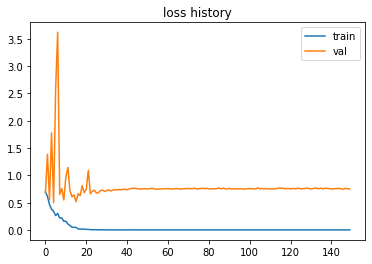

In [13]:
import matplotlib.pyplot as plt
plt.plot(loss_history['train'])
plt.plot(loss_history['val'])
plt.legend(['train','val'])
plt.title('loss history')

Text(0.5, 1.0, 'perplexity=5 accuracy history')

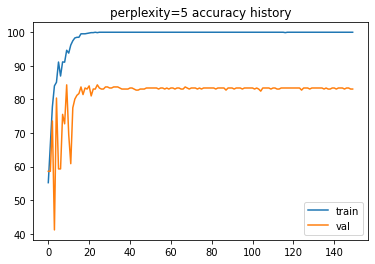

In [14]:
plt.plot(metric_history['train'])
plt.plot(metric_history['val'])
plt.legend(['train','val'])
plt.title('perplexity=5 accuracy history')

Text(0.5, 1.0, 'perplexity=5 auc history')

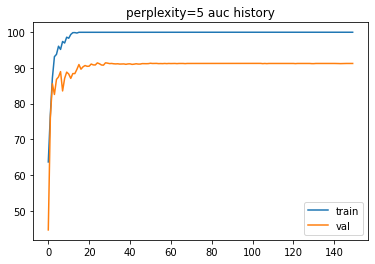

In [15]:
plt.plot(auc_history['train'])
plt.plot(auc_history['val'])
plt.legend(['train','val'])
plt.title('perplexity=5 auc history')